In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import OrderedDict

import sys
sys.path.append('../')

from best.mdp import MDP, ParallelMDP

###### ROVER MODEL (deterministic for now..) ######

n_r = 11  # number of rover states

# Move left
T1_stay = np.diag(np.ones(n_r))

# Move left
T1_west = np.diag(np.ones(n_r-1), -1)
T1_west[0, 0] = 1

# Mover right
T1_east = np.diag(np.ones(n_r-1), 1)
T1_east[n_r-1, n_r-1] = 1


def input_fcn(inp):  # -1, 0, 1
    return inp+1
    
def output_fcn(n):    # -nr/2, ..., nr/2
    return n

rov_x = MDP([T1_west, T1_stay, T1_east], output_name='rx', output_fcn=output_fcn, 
                                input_name='ux', input_fcn=input_fcn)

rov_y = MDP([T1_west, T1_stay, T1_east], output_name='ry', output_fcn=output_fcn, 
                                input_name='uy', input_fcn=input_fcn)

rover = ParallelMDP([rov_x, rov_y])

print rover

Using numpy backend.


MDP: 9 inputs "(ux, uy)" --> 121 outputs "(rx, ry)"


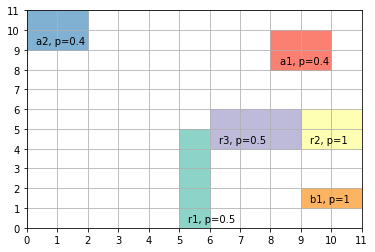

In [2]:
# Define regions
regs = OrderedDict()

def r1(r):
    return r[0] in [5] and r[1] in [0,1,2,3,4]

def r2(r):
    return r[0] in [9,10] and r[1] in [4,5]

def r3(r):
    return r[0] in [6,7,8] and r[1] in [4,5]

def a1(r):
    return r[0] in [8,9] and r[1] in [8, 9]

def a2(r):
    return r[0] in [0,1] and r[1] in [9, 10]

def b1(r):
    return r[0] in [9,10] and r[1] in [1]


regs['r1'] = (r1, 0.5)
regs['r2'] = (r2, 1)
regs['r3'] = (r3, 0.5)
regs['a1'] = (a1, 0.4)
regs['a2'] = (a2, 0.4)
regs['b1'] = (b1, 1)

fig = plt.figure()
ax=fig.gca()
ax.set_xticks(np.arange(0, n_r+1, 1))
ax.set_yticks(np.arange(0, n_r+1, 1))
plt.grid()

def plot_region(func, p, color, name):
    text = 0
    for ix in range(n_r):
        for iy in range(n_r):
            if func([ix, iy]):
                ax.add_patch(patches.Rectangle( (ix, iy), 1, 1, color=color ))
                if not text:
                    ax.text(ix+0.3, iy+0.3, '{}, p={}'.format(name, p))
                    text = 1
                
cm = plt.get_cmap('Set3')

i = 0
for (name, info) in regs.iteritems():
    plot_region(info[0], info[1], cm(i), name)
    i += 1

In [3]:
## Environment belief model

def get_mdp(p0, qw, name):
    # Create map belief MDP with prior p0 and qw quality of weak measurements
    if p0 == 0:
        # no dynamics
        Tnone = np.array([1])
        Tweak = np.array([1])
        Tstrong = np.array([1])
        output_fcn = lambda s: 0
    
    elif p0 == 1:
        Tnone = np.array([1])
        Tweak = np.array([1])
        Tstrong = np.array([1])
        output_fcn = lambda s: 1
        
    else:
        pm = p0/2
        pp = p0 + (1-p0)/2
        # levels [0 p- p0 p+ 1]

        Tnone = np.eye(5);
        Tweak = np.array([[1,           0,             0,       0,              0], 
                          [qw*(1-pm),   (1-qw)*(1-pm), 0,       (1-qw)*pm,      qw*pm],
                          [qw*(1-p0),   (1-qw)*p0,     0,       (1-qw)*(1-p0),  qw*p0],
                          [qw*(1-pp),   (1-qw)*(1-pp), 0,       (1-qw)*pp,      qw*pp],
                          [0,           0,             0,       0,              1]])
        Tstrong = np.array([[1,      0, 0, 0, 0],
                            [(1-pm), 0, 0, 0, pm],
                            [(1-p0), 0, 0, 0, p0],
                            [(1-pp), 0, 0, 0, pp],
                            [0,      0, 0, 0, 1]])

        def output_fcn(s):
            return [0, pm, p0, pp, 1][s]
    
    return MDP([Tnone, Tweak, Tstrong], input_name=name+'_u', output_name=name+'_b', output_fcn=output_fcn)

env = ParallelMDP([get_mdp(info[1], 0.1, name) for (name, info) in regs.iteritems()])

print env
print env.N_list

MDP: 729 inputs "(r1_u, r2_u, r3_u, a1_u, a2_u, b1_u)" --> 625 outputs "(r1_b, r2_b, r3_b, a1_b, a2_b, b1_b)"
[5, 1, 5, 5, 5, 1]


In [4]:
## Connect Rover-env

def is_adjacent(func, x):
    # return true x within distance 1 of func
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if func((x[0]+dx, x[1]+dy)):
                return True
    return False

def connection(xr):
    ret = [0 for i in range(len(regs))]
    i = 0
    for (name, info) in regs.iteritems():
        if is_adjacent(info[0], xr):
            ret[i] = 2    # strong measurement
        i += 1
            
    return set([tuple(ret)])

prod_mdp = rover.product(env, connection=connection)
print prod_mdp

MDP: 9 inputs "(ux, uy)" --> 75625 outputs "((rx, ry), (r1_b, r2_b, r3_b, a1_b, a2_b, b1_b))"


In [5]:
## Set up LTL problem

formula = '( ! fail U sampleA ) & ( ! fail U sampleB )'

# map ((rx, ry), (e1, ..., en)) -> 2^2^{sampleA, sampleB, fail}
def ltl_connection(xr_env):
    xr = xr_env[0]
    env = xr_env[1]
    
    i = 0
    
    ret = set([])
    
    for (name, info) in regs.iteritems():
        func = info[0]
        
        if name[0] == 'r' and func(xr) and env[i] > 0:
            # we are in risk reg that is not confirmed safe 
            ret |= set(['fail'])
            
        if name[0] == 'a' and func(xr) and env[i] == 1:
            # we are in target reg with confirmed sample
            ret |= set(['sampleA'])

        if name[0] == 'b' and func(xr) and env[i] == 1:
            # we are in target reg with confirmed sample
            ret |= set(['sampleB'])
        i += 1

    return set([tuple(ret)])

print ltl_connection(((9,5), (0,0,0,0,0,1)))
print ltl_connection(((9,5), (0,0.1,0,0,0,0)))

print ltl_connection(((9,1), (0,0,0,0,0,0)))
print ltl_connection(((9,1), (0,0,0,0,0,1)))

set([()])
set([('fail',)])
set([()])
set([('sampleB',)])


In [ ]:
from best.ltl import solve_ltl_cosafe
pol = solve_ltl_cosafe(prod_mdp, formula, ltl_connection, delta=0.01, verbose=True)

iteration 0, time 4.88758087158e-05
iteration 1, time 7.38167190552
iteration 2, time 11.9876899719
iteration 3, time 16.6215379238
iteration 4, time 21.4229409695
iteration 5, time 26.3536589146
iteration 6, time 31.0062580109
iteration 7, time 35.6225438118
iteration 8, time 40.2235019207
iteration 9, time 44.8393759727
iteration 10, time 49.6645209789
iteration 11, time 54.2503228188
iteration 12, time 58.8015878201
iteration 13, time 63.3573858738
iteration 14, time 67.9759879112
iteration 15, time 72.5815019608
iteration 16, time 77.0860438347
iteration 17, time 81.5844538212
iteration 18, time 86.0797379017
iteration 19, time 90.5798869133
iteration 20, time 95.0541620255
iteration 21, time 99.5590510368


In [8]:
if False:
    # theano
    import theano.tensor as T
    from theano import function
    
    from best.ltl import formula_to_mdp
    
    dfsa, dfsa_init, dfsa_final, _ = formula_to_mdp(formula)
    prod3mdp = prod_mdp.product(dfsa, ltl_connection)
    
    sV_XEP = T.ftensor3('V_XEP')
    sT_uxX = T.ftensor3('T_uxX')
    sT_veE = T.ftensor3('T_veE')
    sT_wpP = T.ftensor3('T_wpP')
    sU_vX  = T.fmatrix('U_vX')
    sU_wXE = T.ftensor3('U_wXE')
    
    # sum over w
    sS_XEpP = T.tensordot( sU_wXE, sT_wpP, axes=[[0], [0]] )
    sS_XeE = T.tensordot( sU_vX, sT_veE, axes=[[0], [0]] )

    # sum over P
    sW_XEpXE = T.tensordot( sS_XEpP, sV_XEP, axes=[[3], [2]] )
    
    # diagnonal over X
    sW_EpEX = T.diagonal( sW_XEpXE, axis1=0, axis2=3 )
    # diagonal over E
    sW_pXE = T.diagonal( sW_EpEX, axis1=0, axis2=2 )
    
    # sum over E
    sW_XepX = T.tensordot( sS_XeE, sW_pXE, axes=[[2], [2]])
        
    # diagonal over X  (diagonal dim is appended)
    sV_epX = T.diagonal( sW_XepX, axis1=0, axis2=3 )

    # sum over X
    sV_uxep = T.tensordot( sT_uxX, sV_epX, axes=[[2], [2]] )

    # max over u
    sV_xep = T.max(sV_uxep, axis=0)

    f = function([sV_XEP, sT_uxX, sT_veE, sT_wpP, sU_vX, sU_wXE], sV_xep, allow_input_downcast=True)
    
    V = np.zeros(prod3mdp.N_list)
    V[:,:,list(dfsa_final)[0]] = 1
    
    T_uxX = np.array([prod3mdp.mdplist[0].T(m).todense() for m in range(prod3mdp.mdplist[0].M)])
    T_veE = np.array([prod3mdp.mdplist[1].T(m).todense() for m in range(prod3mdp.mdplist[1].M)])
    T_wpP = np.array([prod3mdp.mdplist[2].T(m).todense() for m in range(prod3mdp.mdplist[2].M)])

    U_vX = prod3mdp.conn_list[0]
    U_wXE = prod3mdp.conn_list[1]

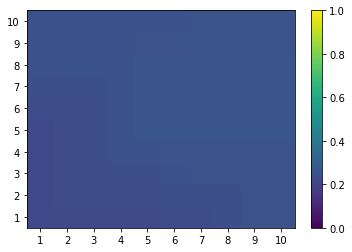

In [9]:
cm = plt.get_cmap('winter')
    
def my_value(x, mapstate):    
   
    s_tot = prod_mdp.global_state( (x, mapstate) )

    _, val = pol.get_input(s_tot)
    return val

pinit = [4, 0, 2, 2, 2, 0]

fig = plt.figure()
ax=fig.gca()
ax.set_xticks(np.arange(0, n_r+1, 1))
ax.set_yticks(np.arange(0, n_r+1, 1))
plt.grid()
        
x_edge = np.arange(0,n_r)
y_edge = np.arange(0,n_r)

xi, yi = np.meshgrid(x_edge,y_edge)
vals = np.array([my_value((x,y), pinit) for (x,y) in zip(xi, yi)])

plt.pcolor(x_edge+0.5, y_edge+0.5, vals.reshape((n_r, n_r)), vmin=0, vmax=1)
plt.colorbar()


In [10]:
# Copter system

n_r = 11  # number of rover states

# Move left
T1_stay = np.diag(np.ones(n_r))

# Move left
T1_west = np.diag(np.ones(n_r-1), -1)
T1_west[0, 0] = 1

# Mover right
T1_east = np.diag(np.ones(n_r-1), 1)
T1_east[n_r-1, n_r-1] = 1

T1_up = np.array([[0, 1], [0, 1]]);
T1_down = np.array([[1, 0], [1, 0]]);

def input_fcn(inp):  # -1, 0, 1
    return inp+1
    
def output_fcn(n):    # -nr/2, ..., nr/2
    return n

cop_x = MDP([T1_west, T1_stay, T1_east], output_name='rx', output_fcn=output_fcn, 
                                input_name='ux', input_fcn=input_fcn)

cop_y = MDP([T1_west, T1_stay, T1_east], output_name='ry', output_fcn=output_fcn, 
                                input_name='uy', input_fcn=input_fcn)

cop_z = MDP([T1_down, T1_up], output_name='rz', output_fcn=output_fcn, 
                              input_name='uy', input_fcn=input_fcn)

copter = ParallelMDP([cop_x, cop_y, cop_z])

print copter

MDP: 18 inputs "(ux, uy, uy)" --> 242 outputs "(rx, ry, rz)"


In [11]:
# connect copter with map
dist = 3

def is_above(func, x):
    # return true x within distance 1 of func
    if func( (x[0], x[1]) ):
        return True
    return False

def is_adjacent(func, x):
    # return true x within distance 1 of func
    for dx in range(-dist, dist+1, 1):
        for dy in range(-dist, dist+1, 1):
            if func((x[0]+dx, x[1]+dy)):
                return True
    return False

def copt_env(xr):
    ret = [0 for i in range(len(regs))]
    i = 0
    for (name, info) in regs.iteritems():
        if is_above(info[0], xr) and xr[2] == 0:
            ret[i] = 1    # weak measurement
        if is_adjacent(info[0], xr) and xr[2] == 1:
            ret[i] = 2    # strong measurement
        i += 1
        
    return set([tuple(ret)])

mdp_copt_env = copter.product(env, connection=copt_env)
print mdp_copt_env

MDP: 18 inputs "(ux, uy, uy)" --> 151250 outputs "((rx, ry, rz), (r1_b, r2_b, r3_b, a1_b, a2_b, b1_b))"


In [15]:
# Solve problem for copter
MAX_STEP = 10  # copter only has 10 steps


def copt_safe(x):
    if x[0] == 4 and x[1] == 0 and x[2] == 0:
        return 1
    else:
        return 0

# value function at time t: rover success probability * copter safe
VT = np.zeros(mdp_copt_env.N_list)

for n in range(copter.N):
    x = copter.output(n)
    if copt_safe(x):
        for m in range(env.N):
            maps = env.local_states(m)
            VT[n, m] = my_value( (0,0), maps )

T_vxX = np.array([copter.T(m).todense() for m in range(copter.M)])
T_ueE = np.array([env.T(m).todense() for m in range(env.M)])
U_uX = mdp_copt_env.conn_list[0]

print T_vxX.shape
print T_ueE.shape
print U_uX.shape

(18, 242, 242)
(729, 625, 625)
(729, 242)


In [24]:
import time

# run value iteration TODO: write exploiting sparsity
Vt_list = [VT]

t0 = time.time()
for step in range(MAX_STEP):
    print 'step {}, time {}'.format(step, time.time()-t0)
    # W_{x', e'}
    W = Vt_list[-1]
    
    # W_{x', e} = \sum_{u, e'} U_{u, x'} T_{u, e, e'} W_{x', e'} 
    W = np.einsum('uX,ueE,XE->Xe', U_uX, T_ueE, W )
    
    # Wv_{v, x, e} = \sum_{x'} T_{v, x, x'} W_{x', e}   
    Wv = np.einsum('vxX,Xe->vxe', T_vxX, W)
    
    # W_{v, x} = \max_{v} Wv_{v, x, e}
    Vt = Wv.max(axis=0)
    
    Vt_list.append(Vt)

step 0, time 0.000221967697144
step 1, time 93.6423590183
step 2, time 187.343376875
step 3, time 281.734480858
step 4, time 372.178216934
step 5, time 461.915452957
step 6, time 552.300893068
step 7, time 642.217705011
step 8, time 731.713979959
step 9, time 821.901067972


0.37871023437499995


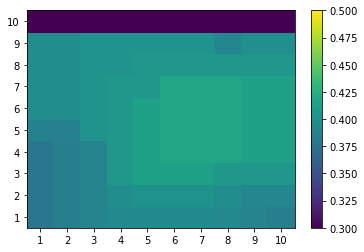

In [44]:
cm = plt.get_cmap('winter')
    
def copter_value(x, mapstate):  
    
    ncop = copter.global_state(x)
    nmap = env.global_state(mapstate)

    return Vt_list[8][ncop, nmap]

pinit = [2, 0, 2, 2, 2, 0]

print copter_value( (0, 0, 0), pinit )

fig = plt.figure()
ax=fig.gca()
ax.set_xticks(np.arange(0, n_r+1, 1))
ax.set_yticks(np.arange(0, n_r+1, 1))
plt.grid()

x_edge = np.arange(0,n_r)
y_edge = np.arange(0,n_r)

xi, yi = np.meshgrid(x_edge,y_edge)
vals = np.array([copter_value((x,y, 0), pinit) for (x,y) in zip(xi, yi)])

plt.pcolor(x_edge+0.5, y_edge+0.5, vals.reshape((n_r, n_r)), vmin=0.3, vmax=0.5)
plt.colorbar()

In [45]:
Vt.shape

(242, 625)

In [46]:
pol.V.shape

(5, 75625)